In [22]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE, mutual_info_classif, RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# load client and invoice datasets
client_train = pd.read_csv('data/client_train.csv')
client_test = pd.read_csv('data/client_test.csv')

invoice_train = pd.read_parquet('data/invoice_train_compressed.csv.parquet')
invoice_test = pd.read_parquet('data/invoice_test_compressed.csv.parquet')

In [5]:
# merge client and invoice training and testing dataset
merged_df = pd.merge(invoice_train, client_train, on='client_id', how='inner')

merged_test = pd.merge(invoice_test, client_test, on='client_id', how='inner')

In [6]:
# Identify categorical variables in the merged dataset
categorical_features = ['disrict', 'client_catg', 'region', 'tarif_type', 
                       'counter_statue', 'reading_remarque', 'counter_type']

In [49]:
# Step 2: Handling Categorical Variables with One-Hot Encoding
# Apply one-hot encoding to the categorical features
#merged_df_encoded = pd.get_dummies(merged_df, columns=categorical_features, drop_first=True)

In [50]:
print(merged_df.head())

        client_id invoice_date  tarif_type  counter_number counter_statue  \
0  train_Client_0   2014-03-24          11         1335667              0   
1  train_Client_0   2013-03-29          11         1335667              0   
2  train_Client_0   2015-03-23          11         1335667              0   
3  train_Client_0   2015-07-13          11         1335667              0   
4  train_Client_0   2016-11-17          11         1335667              0   

   counter_code  reading_remarque  counter_coefficient  consommation_level_1  \
0           203                 8                    1                    82   
1           203                 6                    1                  1200   
2           203                 8                    1                   123   
3           207                 8                    1                   102   
4           207                 9                    1                   572   

   consommation_level_2  ...  consommation_level_4  old_

In [7]:
# Step 2: Handling Categorical Variables with Label Encoding
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))  # Convert to string in case there are mixed types
    label_encoders[col] = le  # Store the encoder for potential inverse_transform

# Verify the encoding by displaying the first few rows of the categorical columns
print(merged_df[categorical_features].head())


   disrict  client_catg  region  tarif_type  counter_statue  reading_remarque  \
0        0            0       0           1               0                 6   
1        0            0       0           1               0                 4   
2        0            0       0           1               0                 6   
3        0            0       0           1               0                 6   
4        0            0       0           1               0                 7   

   counter_type  
0             0  
1             0  
2             0  
3             0  
4             0  


In [8]:
# Step 3: Split the merged data into train and test sets
# Specify features for training excluding irrelevant columns like 'client_id'
features_for_selection = merged_df.drop(columns=['client_id', 'target', 'invoice_date','creation_date']).columns
X = merged_df[features_for_selection]
y = merged_df['target'].astype(int)  # Convert target to integer if it's in string form
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
print(X_train.dtypes)

invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue           int64
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type             int64
disrict                  int64
client_catg              int64
region                   int64
creation_date           object
dtype: object


In [9]:
# Step 4: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Class Distribution After SMOTE:
target
0    3298562
1    3298562
Name: count, dtype: int64


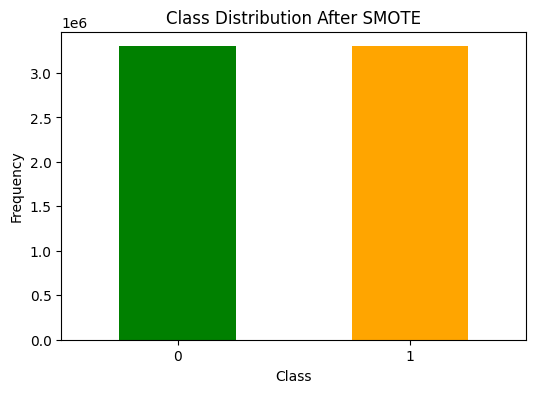

In [10]:
# Step 5: Check class distribution after applying SMOTE
class_counts_after_smote = y_train_smote.value_counts()
print("Class Distribution After SMOTE:")
print(class_counts_after_smote)

# Plot the class distribution after SMOTE
plt.figure(figsize=(6, 4))
class_counts_after_smote.plot(kind='bar', color=['green', 'orange'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [18]:
print(len(features_for_selection))

17


In [12]:
# Step 6: Feature Selection using RFECV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=model, step=2, cv=cv, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train_smote, y_train_smote)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
      scoring='accuracy', step=2)

In [13]:
# Get the optimal number of features and the selected features
optimal_num_features = rfecv.n_features_
selected_features_rfecv = X_train_smote.columns[rfecv.support_]
print("Optimal number of features selected by RFECV after RFE pruning:", optimal_num_features)
print("Selected features using RFECV after RFE pruning:")
print(selected_features_rfecv)


Optimal number of features selected by RFECV after RFE pruning: 5
Selected features using RFECV after RFE pruning:
Index(['counter_number', 'counter_code', 'consommation_level_1', 'old_index',
       'region'],
      dtype='object')


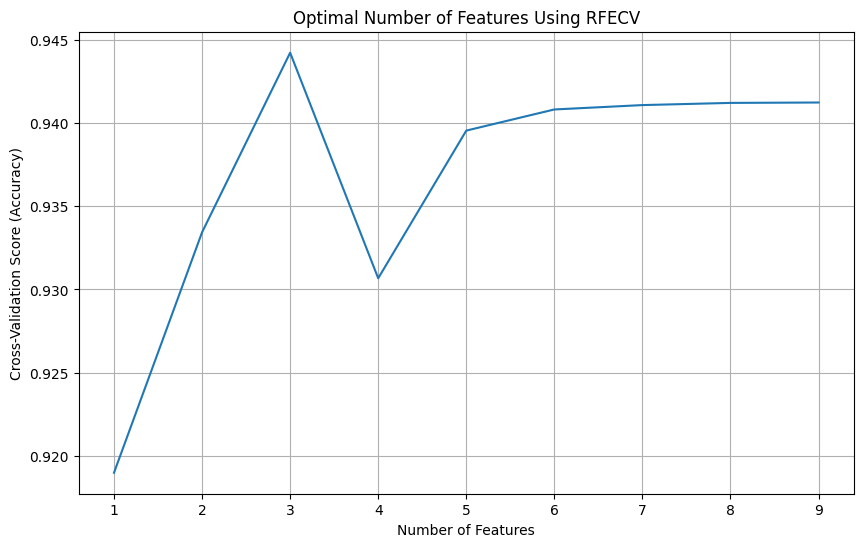

In [15]:
# Plot the number of features vs cross-validation score
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Score (Accuracy)')
plt.title('Optimal Number of Features Using RFECV')
plt.grid()
plt.show()

In [19]:
# Step 8: Iterative Feature Selection Using Mutual Information
mutual_info_series = mutual_info_classif(X_train_smote, y_train_smote)
mutual_info_series = pd.Series(mutual_info_series, index=X_train.columns).sort_values(ascending=False)

max_features = 17  
best_score = 0
best_k = 0

for k in range(1, max_features + 1):
    selected_features = mutual_info_series.head(k).index
    X_train_selected = X_train_smote[selected_features]
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train_selected, y_train_smote, cv=5, scoring='accuracy', n_jobs=-1)
    mean_score = np.mean(scores)
    
    print(f"Number of features: {k}, Cross-Validation Score: {mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Optimal number of features based on cross-validation: {best_k}")
selected_features_mi_optimal = mutual_info_series.head(best_k).index
print("Selected features using optimal Mutual Information selection:")
print(selected_features_mi_optimal)

Number of features: 1, Cross-Validation Score: 0.5795
Number of features: 2, Cross-Validation Score: 0.6475
Number of features: 3, Cross-Validation Score: 0.6634
Number of features: 4, Cross-Validation Score: 0.6670
Number of features: 5, Cross-Validation Score: 0.6670
Number of features: 6, Cross-Validation Score: 0.7245
Number of features: 7, Cross-Validation Score: 0.7245
Number of features: 8, Cross-Validation Score: 0.9776
Number of features: 9, Cross-Validation Score: 0.9692
Number of features: 10, Cross-Validation Score: 0.9458
Number of features: 11, Cross-Validation Score: 0.9467
Number of features: 12, Cross-Validation Score: 0.9393
Number of features: 13, Cross-Validation Score: 0.9392
Number of features: 14, Cross-Validation Score: 0.9383
Number of features: 15, Cross-Validation Score: 0.9387
Number of features: 16, Cross-Validation Score: 0.9386
Number of features: 17, Cross-Validation Score: 0.9388
Optimal number of features based on cross-validation: 8
Selected features 

In [23]:
# Step 9: Model Training and Evaluation Using Selected Features
feature_sets = {
    'RFECV': selected_features_rfecv,
    'Mutual Information': selected_features_mi_optimal,
    'All Features': features_for_selection
}

for name, features in feature_sets.items():
    print(f"\nTraining model using {name} features...")
    X_train_final = X_train_smote[features]
    X_test_final = X_test[features]
    
    # Train the model
    model.fit(X_train_final, y_train_smote)
    
    # Make predictions
    y_pred = model.predict(X_test_final)
    
    # Evaluate the model
    print(f"Evaluation Report for {name} Features:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Calculate and print accuracy
    accuracy = model.score(X_test_final, y_test)
    print(f"Accuracy for {name} features: {accuracy:.4f}")


Training model using RFECV features...
Evaluation Report for RFECV Features:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    825075
           1       0.59      0.84      0.69     70275

    accuracy                           0.94    895350
   macro avg       0.79      0.89      0.83    895350
weighted avg       0.95      0.94      0.95    895350

ROC AUC Score: 0.8925936864638062
Confusion Matrix:
[[783901  41174]
 [ 11589  58686]]
Accuracy for RFECV features: 0.9411

Training model using Mutual Information features...
Evaluation Report for Mutual Information Features:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    825075
           1       0.89      0.98      0.93     70275

    accuracy                           0.99    895350
   macro avg       0.94      0.98      0.96    895350
weighted avg       0.99      0.99      0.99    895350

ROC AUC Score: 0.983998789799873
Confusio